# Telecom Customer Churn Prediction
By Hans Darmawan - JCDS2602

---
## Section 1. Business Understanding
### 1.1 Context
The dataset contains customer information from a telecom company including demographics, services subscribed, account information, and churn status. The business context is to predict customer churn to enable targeted retention strategies.

### 1.2 Problem Statements
- Which customers are likely to churn?
- What factors influence customer churn the most?
- How can the company reduce churn and improve customer retention?

### 1.3 Goals
- Develop a predictive model to classify customers as churn or no churn.
- Identify key features affecting churn.
- Provide actionable insights for business to reduce churn.

### 1.4 Analytical Approach
- Use supervised machine learning classification techniques.
- Data preprocessing including cleaning, feature engineering.
- Model development with benchmarking, tuning, and evaluation.
- Model explanation using feature importance and SHAP values.

### 1.5 Metric Evaluation
- Business Metric: Reduction in churn rate.
- Machine Learning Evaluation Metric: Accuracy, Precision, Recall, F1-score, ROC-AUC.

### 1.6 Success Criteria
- Achieve high classification performance (e.g., ROC-AUC > 0.80).
- Provide interpretable insights for business decisions.
- Demonstrate model effectiveness on unseen data.

## Section 2. Data Understanding
### 2.1 General Information
- Dataset contains customer records with attributes related to demographics, services, contracts, billing, and churn.
- Target variable: Churn (Yes/No).

In [1]:
# Suppress only specific warnings to avoid hiding important alerts
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress specific warnings
warnings.filterwarnings('ignore')

# Core data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Set Seaborn theme for better aesthetics
sns.set_theme()

# Statistical modeling and diagnostics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine learning and preprocessing libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, BaggingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# Imbalanced data handling
from imblearn.over_sampling import SMOTE, ADASYN

# Model selection and evaluation tools
from sklearn.model_selection import (train_test_split, cross_val_score, StratifiedKFold, 
                                     RandomizedSearchCV, learning_curve)
from sklearn.metrics import (classification_report, roc_auc_score, brier_score_loss,
                             precision_recall_curve, roc_curve, f1_score, recall_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import confusion_matrix

# Other utilities
from scipy.stats import uniform
import shap
import joblib
import os

# Configure pandas display options for better visibility
pd.set_option('display.max_columns', None)

# Load dataset with error handling
data_path = r'C:\Users\User\Documents\Purwadhika\JCDS 2602\Capstone Project\telco-churn\data\raw\data.csv'

try:
    if os.path.exists(data_path):
        real_df = pd.read_csv(data_path)
    else:
        raise FileNotFoundError(f"Data file not found at {data_path}")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")
    raise

# Create a copy of the DataFrame for manipulation
df = real_df.copy()

# Show initial data info and preview
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB
None


,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


### 2.2 Feature Information
| Feature            | Description                                      | Impact to Business                                         |
|--------------------|------------------------------------------------|------------------------------------------------------------|
| customerID         | Unique customer identifier                       | Identification, no direct impact                            |
| gender             | Customer gender (Male, Female)                   | Possible demographic influence                              |
| SeniorCitizen      | Whether the customer is a senior citizen (0,1)  | May affect churn due to different needs                    |
| Partner            | Whether customer has a partner (Yes, No)        | Social factors influencing churn                            |
| Dependents         | Whether customer has dependents (Yes, No)       | Social factors influencing churn                            |
| tenure             | Number of months customer has stayed             | Longer tenure usually means lower churn                     |
| PhoneService       | Whether customer has phone service (Yes, No)    | Service usage influence                                     |
| MultipleLines      | Whether customer has multiple lines (Yes, No, No phone service) | Service usage influence                                     |
| InternetService    | Type of internet service (DSL, Fiber optic, No) | Service type impact on churn                                |
| OnlineSecurity     | Whether customer has online security (Yes, No, No internet service) | Service feature impact                                      |
| OnlineBackup       | Whether customer has online backup (Yes, No, No internet service) | Service feature impact                                      |
| DeviceProtection   | Whether customer has device protection (Yes, No, No internet service) | Service feature impact                                      |
| TechSupport        | Whether customer has tech support (Yes, No, No internet service) | Service feature impact                                      |
| StreamingTV        | Whether customer streams TV (Yes, No, No internet service) | Service feature impact                                      |
| StreamingMovies    | Whether customer streams movies (Yes, No, No internet service) | Service feature impact                                      |
| Contract           | Contract type (Month-to-month, One year, Two year) | Contract length impact on churn                             |
| PaperlessBilling   | Whether customer uses paperless billing (Yes, No) | Billing preference impact                                   |
| PaymentMethod      | Payment method used                               | Billing method impact                                       |
| MonthlyCharges     | Monthly charges                                  | Financial factor influencing churn                          |
| TotalCharges       | Total charges to date                            | Financial factor influencing churn                          |
| Churn              | Whether customer churned (Yes, No)              | Target variable                                            |

### 2.3 Missing Values Checking
Check for missing values and visualize them.

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64


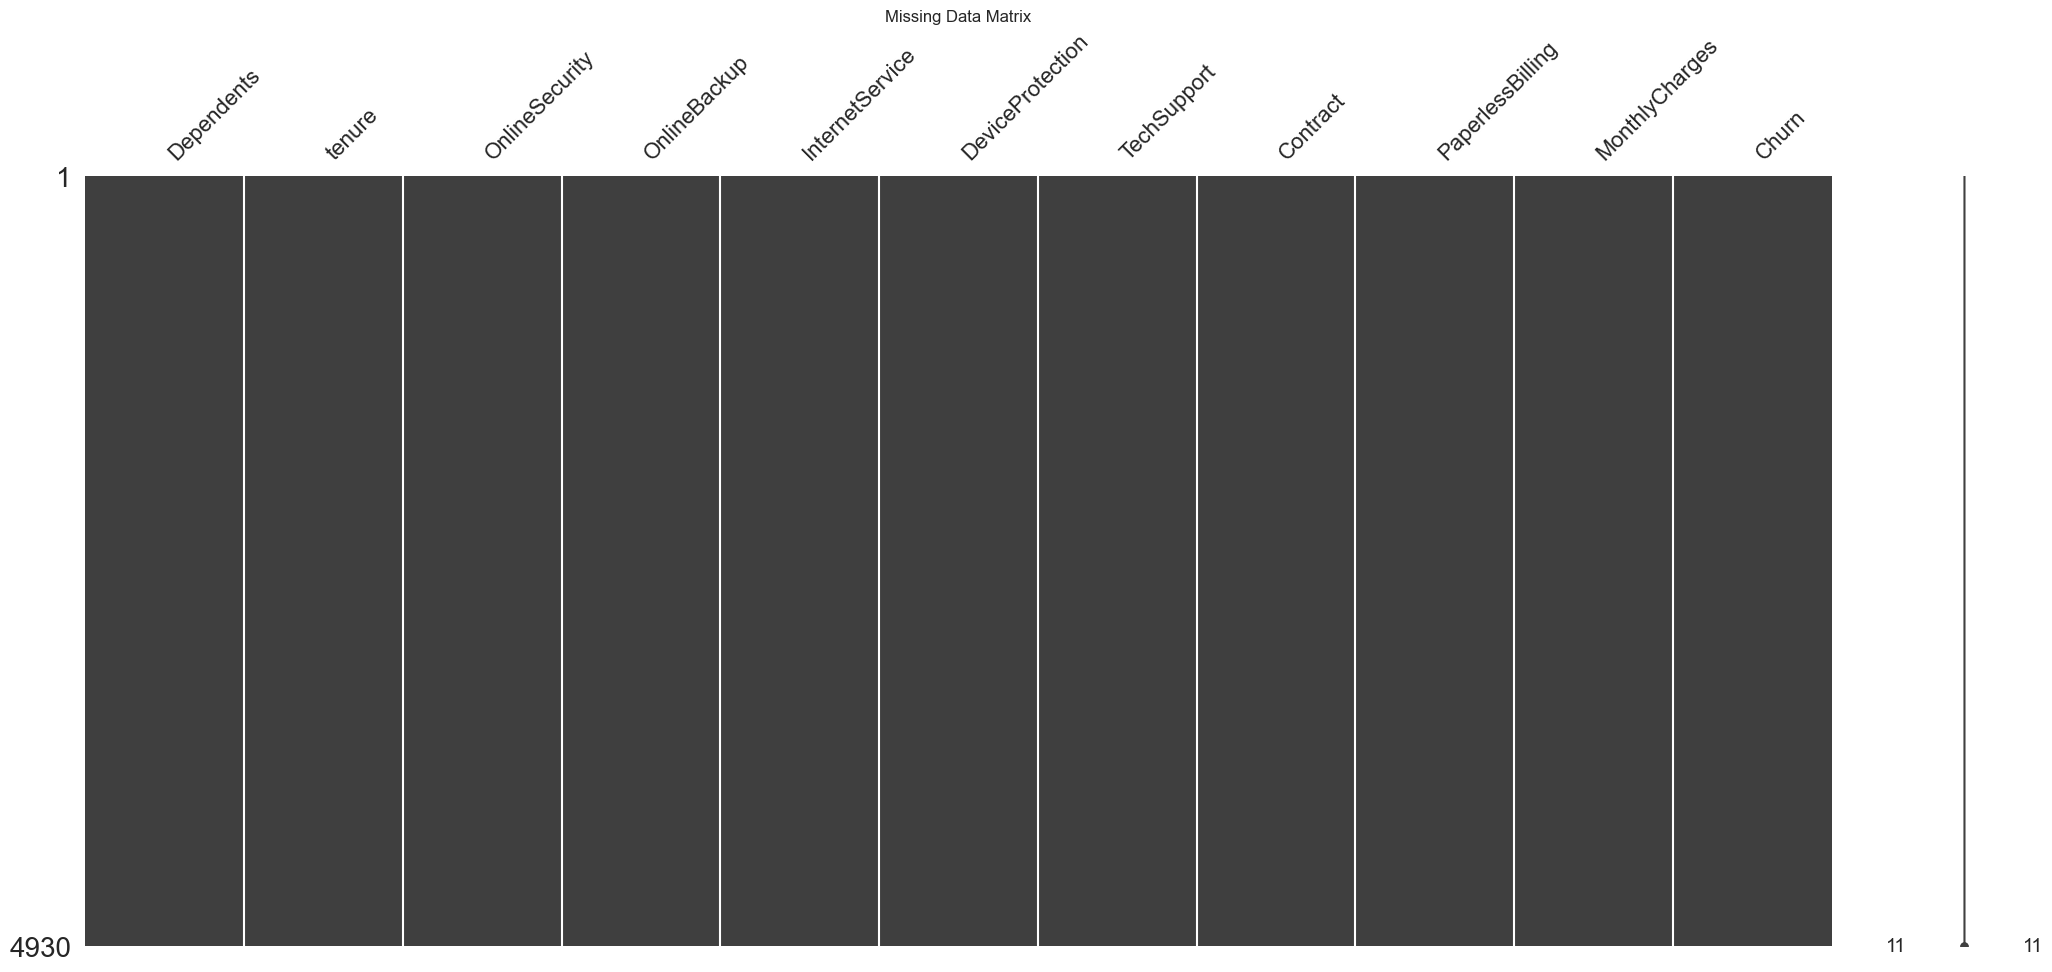

In [2]:
# Check missing values count per column
missing_counts = df.isnull().sum()
print(missing_counts)

# Visualize missing data pattern
msno.matrix(df)
plt.title('Missing Data Matrix')
plt.show()

### 2.4 Duplicated Values Checking
Check for duplicated rows.

In [3]:
# Count duplicated rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 77


### 2.5 Dataset Restructuring for Better EDA
Convert object columns to categorical for memory efficiency and proper analysis.

In [4]:
# Convert object columns to category dtype
object_cols = df.select_dtypes(include=['object']).columns.tolist()
df[object_cols] = df[object_cols].astype('category')

# Confirm changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Dependents        4930 non-null   category
 1   tenure            4930 non-null   int64   
 2   OnlineSecurity    4930 non-null   category
 3   OnlineBackup      4930 non-null   category
 4   InternetService   4930 non-null   category
 5   DeviceProtection  4930 non-null   category
 6   TechSupport       4930 non-null   category
 7   Contract          4930 non-null   category
 8   PaperlessBilling  4930 non-null   category
 9   MonthlyCharges    4930 non-null   float64 
 10  Churn             4930 non-null   category
dtypes: category(9), float64(1), int64(1)
memory usage: 121.6 KB


### 2.6 Exploratory Data Analysis (EDA)
#### 2.6.1 Outlier Analysis

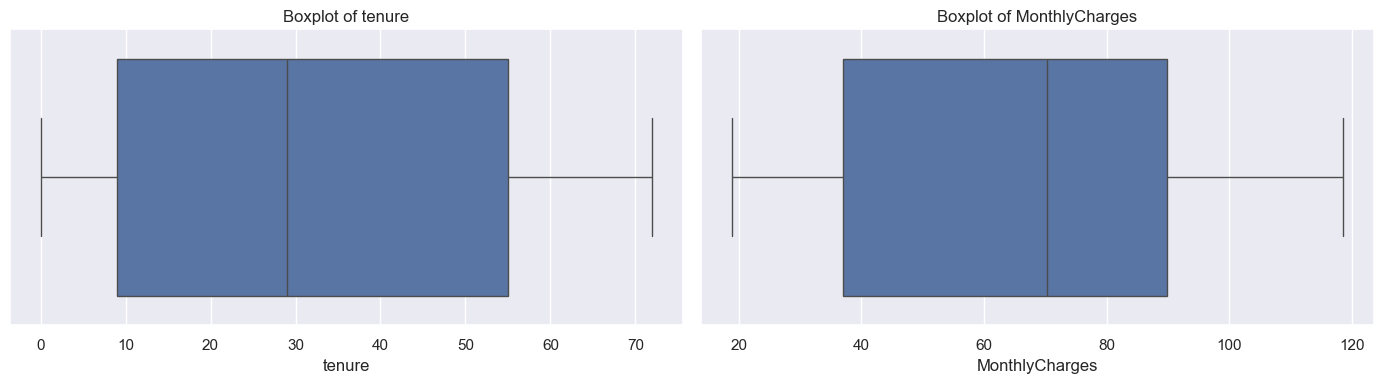

In [5]:
numerics = df.select_dtypes(include=['float64','int64']).columns.tolist()

# Create dynamic grid based on number of numeric columns
num_plots = len(numerics)
cols = 2
rows = (num_plots + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 4))
axes = axes.flatten()

for i, col in enumerate(numerics):
    sns.boxplot(x=df[col], orient='h', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 2.6.2 Unique Values Analysis

In [6]:
cat_cols = df.select_dtypes(include=['category']).columns

# Dictionary of unique counts per categorical column
unique_counts = {col: df[col].nunique() for col in cat_cols}

# Dictionary of unique values lists per categorical column
unique_values_list = {col: df[col].unique().tolist() for col in cat_cols}

unique_summary = pd.DataFrame({'unique_counts': unique_counts, 'unique_values': unique_values_list})
unique_summary

,unique_counts,unique_values
Dependents,2,"[Yes, No]"
OnlineSecurity,3,"[No, Yes, No internet service]"
OnlineBackup,3,"[No, Yes, No internet service]"
InternetService,3,"[DSL, Fiber optic, No]"
DeviceProtection,3,"[Yes, No internet service, No]"
TechSupport,3,"[Yes, No, No internet service]"
Contract,3,"[Month-to-month, Two year, One year]"
PaperlessBilling,2,"[Yes, No]"
Churn,2,"[Yes, No]"


#### 2.6.3 Proportion Analysis

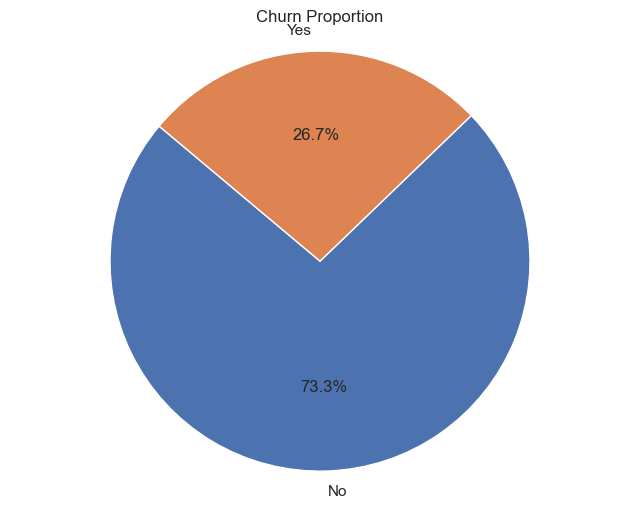

In [7]:
churn_proportion = df['Churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
plt.pie(churn_proportion, labels=churn_proportion.index, autopct='%1.1f%%', startangle=140)
plt.title('Churn Proportion')
plt.axis('equal')  # Equal aspect ratio ensures pie chart is circular
plt.show()

#### 2.6.4 Feature Distribution Analysis (Categorical)

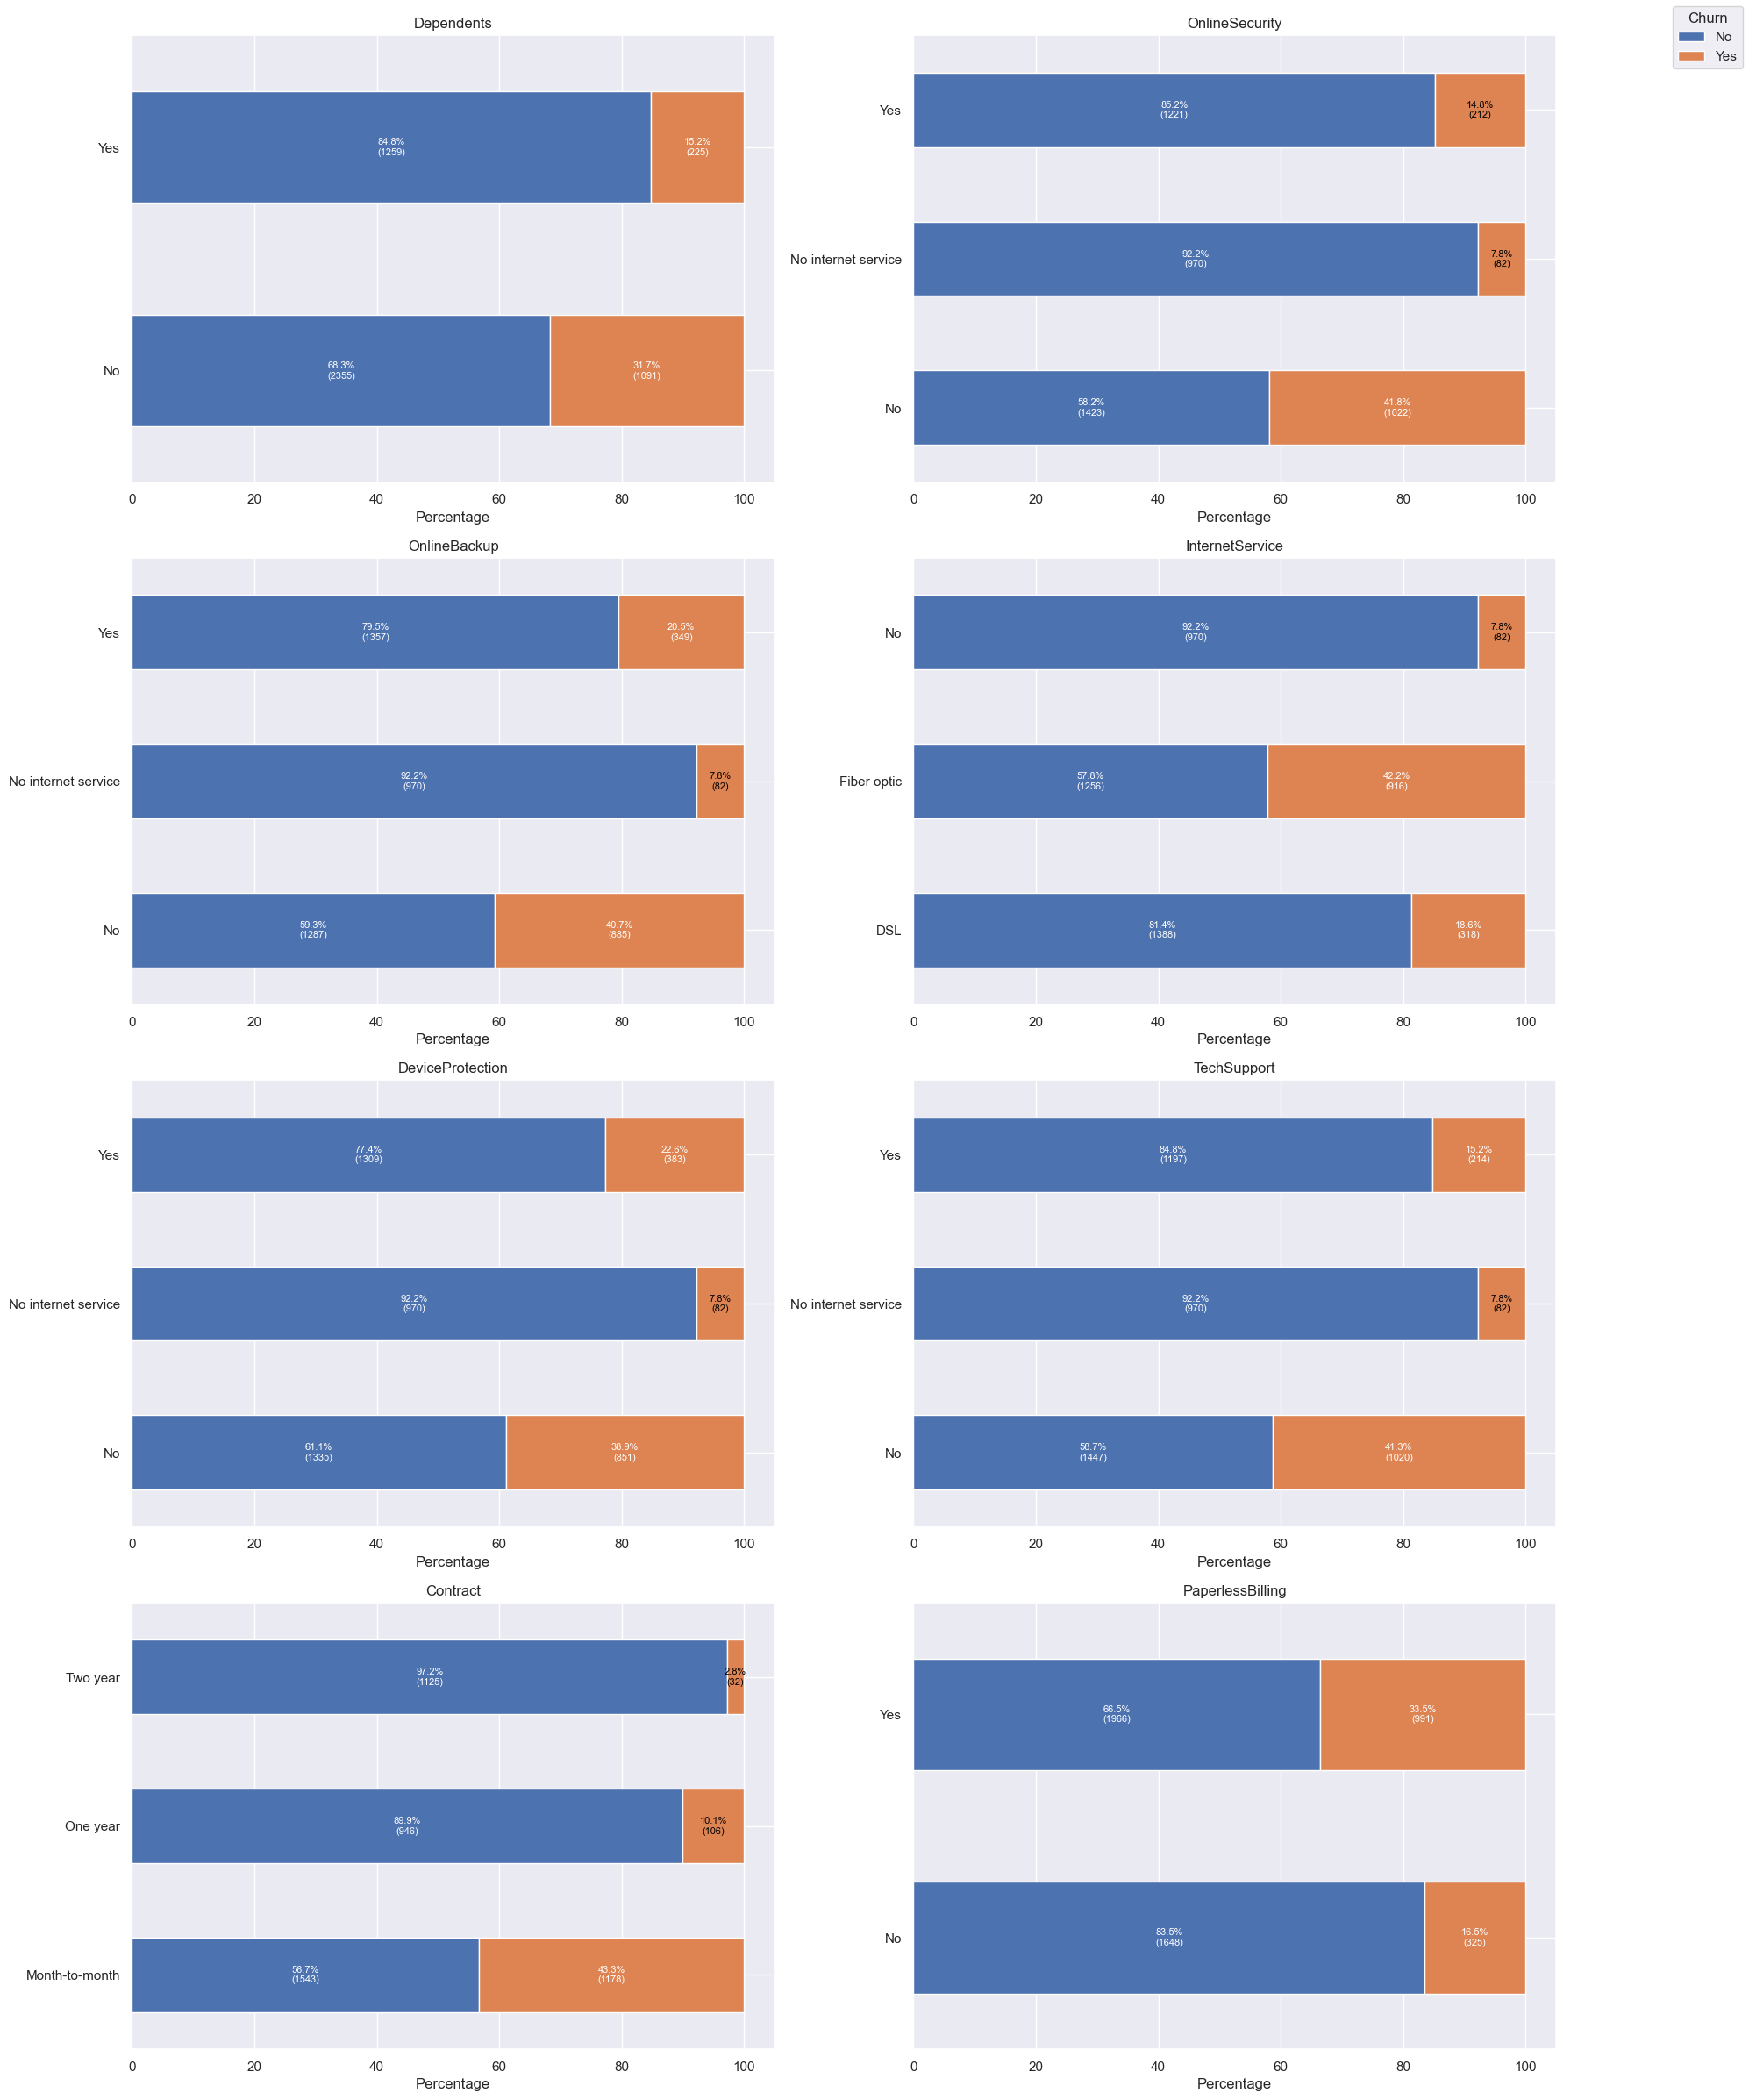

In [8]:
categorical_cols = df.select_dtypes(include='category').columns.drop('Churn')

num_plots = len(categorical_cols)
cols = 2
rows = (num_plots + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 10, rows * 6))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    
    # Compute counts per category and churn status with observed=True
    counts = df.groupby([col, 'Churn'], observed=True).size().unstack(fill_value=0)
    
    # Convert counts to percentages per category level (row-wise)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    
    # Plot horizontal stacked bar chart on the subplot axis
    percentages.plot(kind='barh', stacked=True, ax=ax, legend=False)
    
    ax.set_title(f'{col}')
    ax.set_xlabel('Percentage')
    ax.set_ylabel('')
    
    # Annotate each segment with percentage and count
    for j, (index, row) in enumerate(percentages.iterrows()):
        cum_width = 0
        for churn_status in percentages.columns:
            pct = row[churn_status]
            cnt = counts.loc[index, churn_status]
            if pct > 0:
                label = f'{pct:.1f}%\n({cnt})'
                ax.text(cum_width + pct / 2, j, label, ha='center', va='center', fontsize=8,
                        color='white' if pct > 15 else 'black')
                cum_width += pct

# Remove any unused subplots
for k in range(i + 1, len(axes)):
    fig.delaxes(axes[k])

# Create one legend for all plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Churn', loc='upper right')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on right for legend
plt.show()

#### 2.6.5 Correlation Analysis

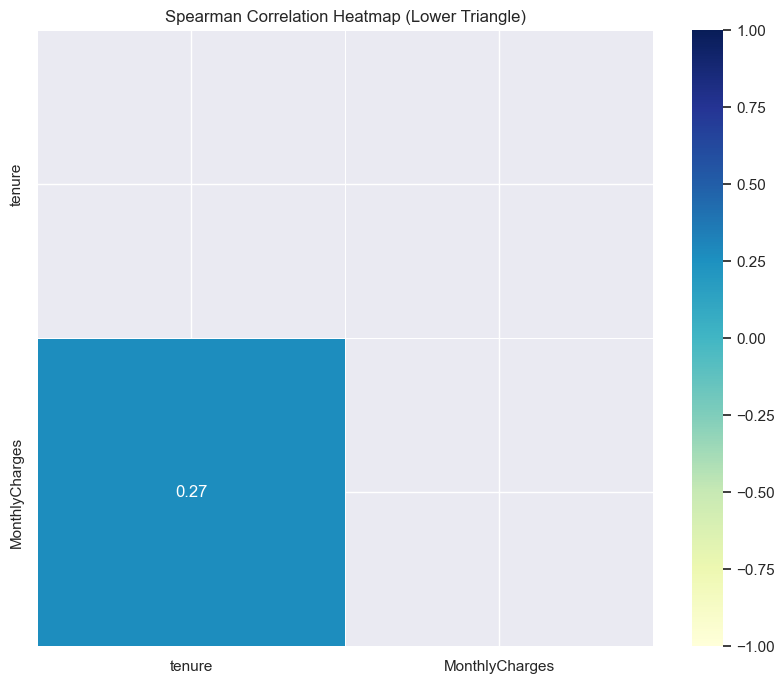

In [9]:
# Compute Spearman correlation matrix for numeric columns
corr = df.corr(numeric_only=True, method='spearman')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap with the mask applied to show only the lower triangle
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='YlGnBu', vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Spearman Correlation Heatmap (Lower Triangle)')
plt.show()

#### 2.6.6 Feature Distribution Analysis (Numerical)

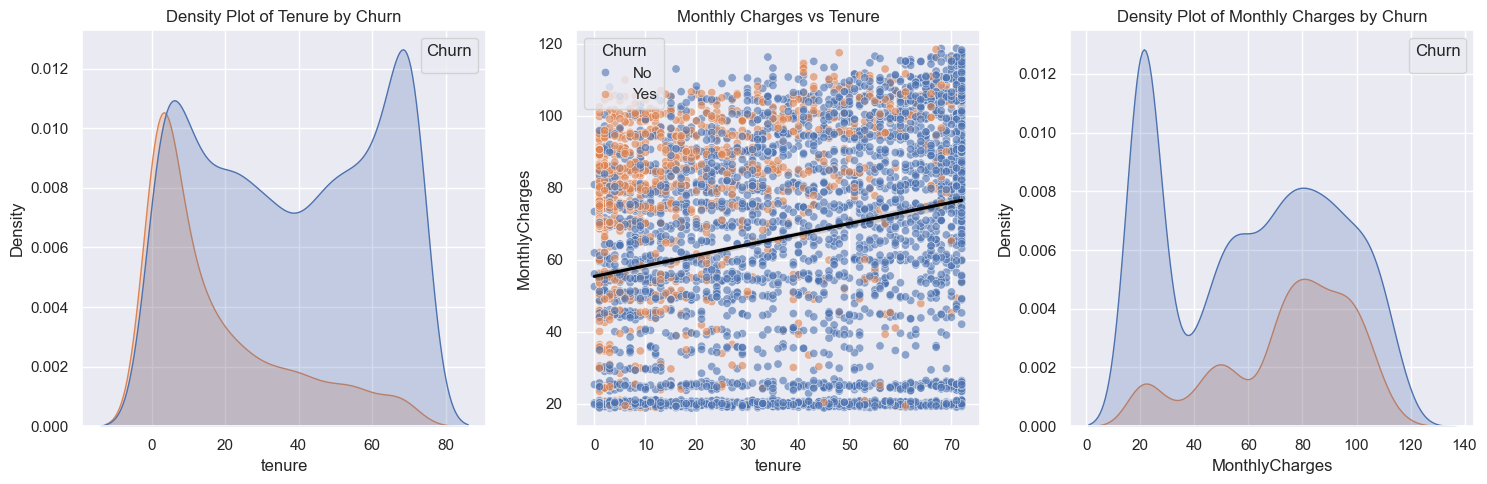

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
# df = your DataFrame containing the data

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1st subplot: KDE plot for 'tenure' by 'Churn'
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, ax=axes[0])
axes[0].set_title('Density Plot of Tenure by Churn')

# 2nd subplot: Scatter plot for 'MonthlyCharges' vs 'tenure' colored by 'Churn'
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn', ax=axes[1], alpha=0.6)

# Add regression line to the scatter plot
sns.regplot(data=df, x='tenure', y='MonthlyCharges', ax=axes[1], scatter=False, color='black')

axes[1].set_title('Monthly Charges vs Tenure')

# 3rd subplot: KDE plot for 'MonthlyCharges' by 'Churn'
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, ax=axes[2])
axes[2].set_title('Density Plot of Monthly Charges by Churn')

# Show the legend
for ax in axes:
    ax.legend(title='Churn')

# Adjust layout
plt.tight_layout()
plt.show()


#### 2.6.7 Statistics Summary

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tenure,4930.0,32.401217,24.501193,0.0,9.00,29.00,55.00,72.00
MonthlyCharges,4930.0,64.883032,29.923960,18.8,37.05,70.35,89.85,118.65


In [12]:
df.describe(include=['object','category']).transpose()

,count,unique,top,freq
Dependents,4930,2,No,3446
OnlineSecurity,4930,3,No,2445
OnlineBackup,4930,3,No,2172
InternetService,4930,3,Fiber optic,2172
DeviceProtection,4930,3,No,2186
TechSupport,4930,3,No,2467
Contract,4930,3,Month-to-month,2721
PaperlessBilling,4930,2,Yes,2957
Churn,4930,2,No,3614


## Section 3. Data Preparation
### 3.1 Feature Engineering

In [13]:
df['TotalCharges'] = df['tenure'] * df['MonthlyCharges']

### 3.2 Target Labeling

In [14]:
# Map target variable 'Churn' from Yes/No to 1/0
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

### 3.3 Define Features and Target

In [15]:
# Define feature matrix X and target vector y
X = df.drop(columns=['Churn'])
y = df['Churn']

### 3.4 Train-Test Split

In [16]:
# Stratified split to maintain target distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 3.5 Data Transformation Setup

In [17]:
# Identify categorical columns excluding target
categorical_cols = [col for col in df.select_dtypes(include=['category']).columns if col != 'Churn']

# Identify numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify binary columns (with exactly 2 unique values excluding 'Churn')
binary_cols = unique_summary[unique_summary['unique_counts'] == 2].index.tolist()
binary_cols = [col for col in binary_cols if col != 'Churn']

# Separate categorical columns into binary and non-binary
categorical_cols_no_binary = [col for col in categorical_cols if col not in binary_cols]

# Function to map 'No'->0 and 'Yes'->1 in binary columns
def map_binary_yes_no(X):
    """
    Map 'No' to 0 and 'Yes' to 1 for binary categorical columns.
    Handles unexpected values by mapping to NaN.
    """
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=binary_cols)
    for col in X.columns:
        X[col] = X[col].map({'No': 0, 'Yes': 1})
        if X[col].isnull().any():
            raise ValueError(f"Unexpected values found in column {col} during binary mapping.")
        X[col] = X[col].astype(np.int64)
    return X.values

# Numeric transformer pipeline: imputation + scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())  # RobustScaler helps with outliers
])

# Binary transformer pipeline: map Yes/No to 0/1
binary_transformer = Pipeline(steps=[
    ('map_yes_no', FunctionTransformer(map_binary_yes_no))
])

# Categorical transformer pipeline: one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Drop first to avoid dummy trap
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('binary', binary_transformer, binary_cols),
        ('cat', categorical_transformer, categorical_cols_no_binary)
    ],
    remainder='passthrough'  # Pass through other columns if any
)

## Section 4. Modeling
### 4.1 Model Initialization and Cross-Validation

In [18]:
# Define models with random_state and n_jobs where applicable
models = {
    'Logistic Regression': LogisticRegression(random_state=42, n_jobs=-1, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42, n_jobs=-1),
    'SVM': SVC(probability=True, random_state=42),
    'k-NN': KNeighborsClassifier(n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)
}

# Use recall scoring to prioritize catching churners
scoring = ['recall', 'f1']

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

list_scores = []

for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    for score in scoring:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=score, n_jobs=-1)
        list_scores.append({
            'Model': model_name,
            'Metric': score,
            'Mean Score': np.mean(scores),
            'Std Dev': np.std(scores)
        })

results_df = pd.DataFrame(list_scores)
results_df = results_df.sort_values(by=['Mean Score', 'Std Dev'], ascending=[False, True])

In [19]:
results_df[results_df['Metric']=='recall']

,Model,Metric,Mean Score,Std Dev
0,Logistic Regression,recall,0.534687,0.030207
18,LightGBM,recall,0.532670,0.044481
6,Gradient Boosting,recall,0.519431,0.031206
20,CatBoost,recall,0.517513,0.029508
16,XGBoost,recall,0.508946,0.037485
14,k-NN,recall,0.490007,0.014979
2,Decision Tree,recall,0.476719,0.019208
4,Random Forest,recall,0.476673,0.030669
12,SVM,recall,0.447271,0.022860
10,Bagging,recall,0.428265,0.025116


In [20]:
results_df[results_df['Metric']=='f1']

,Model,Metric,Mean Score,Std Dev
1,Logistic Regression,f1,0.586293,0.027941
7,Gradient Boosting,f1,0.583901,0.036536
21,CatBoost,f1,0.574972,0.033569
19,LightGBM,f1,0.572754,0.047244
17,XGBoost,f1,0.544138,0.034356
15,k-NN,f1,0.536003,0.008945
13,SVM,f1,0.532250,0.031855
5,Random Forest,f1,0.528744,0.023067
9,AdaBoost,f1,0.506520,0.054179
11,Bagging,f1,0.492506,0.027209


### 4.2 VIF Analysis
Calculate Variance Inflation Factor to detect multicollinearity.

In [21]:
# Fit preprocessor on training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Function to get feature names after preprocessing
def get_feature_names(preprocessor):
    feature_names = []
    feature_names.extend(numeric_cols)
    feature_names.extend(binary_cols)
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_features = ohe.get_feature_names_out(categorical_cols_no_binary)
    feature_names.extend(cat_features)
    return feature_names

feature_names = get_feature_names(preprocessor)

# Convert to DataFrame for VIF calculation
X_vif = pd.DataFrame(X_train_preprocessed, columns=feature_names)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
13,TechSupport_No internet service,inf
11,DeviceProtection_No internet service,inf
5,OnlineSecurity_No internet service,inf
10,InternetService_No,inf
7,OnlineBackup_No internet service,inf
2,TotalCharges,11.758656
1,MonthlyCharges,7.662679
0,tenure,6.604636
9,InternetService_Fiber optic,3.994744
16,Contract_Two year,3.103916


### 4.3 VIF Selector Transformer and Hyperparameter Tuning

In [22]:
class VIFSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to remove features with high Variance Inflation Factor (VIF).
    """
    def __init__(self, threshold=10):
        self.threshold = threshold
        self.features_to_drop_ = []
        self.feature_names_ = None

    def fit(self, X, y=None):
        if hasattr(X, "toarray"):
            X = X.toarray()
        X_df = pd.DataFrame(X, columns=self.feature_names_)

        vif_data = pd.DataFrame()
        vif_data['feature'] = X_df.columns
        vif_vals = []
        for i in range(X_df.shape[1]):
            try:
                vif = variance_inflation_factor(X_df.values, i)
            except Exception:
                vif = np.inf
            vif_vals.append(vif)
        vif_data['VIF'] = vif_vals

        self.features_to_drop_ = vif_data[(vif_data['VIF'] == np.inf) | (vif_data['VIF'] > self.threshold)]['feature'].tolist()
        return self

    def transform(self, X):
        if hasattr(X, "toarray"):
            X = X.toarray()
        X_df = pd.DataFrame(X, columns=self.feature_names_)
        X_reduced = X_df.drop(columns=self.features_to_drop_, errors='ignore')
        return X_reduced.values

    def set_feature_names(self, feature_names):
        self.feature_names_ = feature_names
        return self

# Initialize VIFSelector
vif_selector = VIFSelector(threshold=10).set_feature_names(feature_names)

# Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)

# Resamplers for class imbalance
resamplers = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42)
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter distributions for RandomizedSearchCV
param_dist = [
    {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['saga'],
    },
    {
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__l1_ratio': uniform(0, 1)
    }
]

best_results = {}

for name, sampler in resamplers.items():
    print(f"\nStarting RandomizedSearchCV with {name} resampler...")
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('vif_selector', vif_selector),
        ('resampler', sampler),
        ('classifier', logreg)
    ])

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=50,
        scoring='recall',
        cv=cv,
        verbose=2,
        random_state=42,
        n_jobs=-1,
        refit=True,
        error_score='raise'
    )

    random_search.fit(X_train, y_train)

    print(f"Best recall score with {name}: {random_search.best_score_:.4f}")
    print(f"Best parameters with {name}: {random_search.best_params_}")
    best_results[name] = random_search


Starting RandomizedSearchCV with SMOTE resampler...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best recall score with SMOTE: 0.7816
Best parameters with SMOTE: {'classifier__penalty': 'l2', 'classifier__solver': 'saga'}

Starting RandomizedSearchCV with ADASYN resampler...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best recall score with ADASYN: 0.8196
Best parameters with ADASYN: {'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


### 4.4 Evaluate Best Model on Test Data

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.91      0.72      0.81       723
           1       0.52      0.81      0.63       263

    accuracy                           0.75       986
   macro avg       0.72      0.77      0.72       986
weighted avg       0.81      0.75      0.76       986

ROC-AUC Score: 0.8533


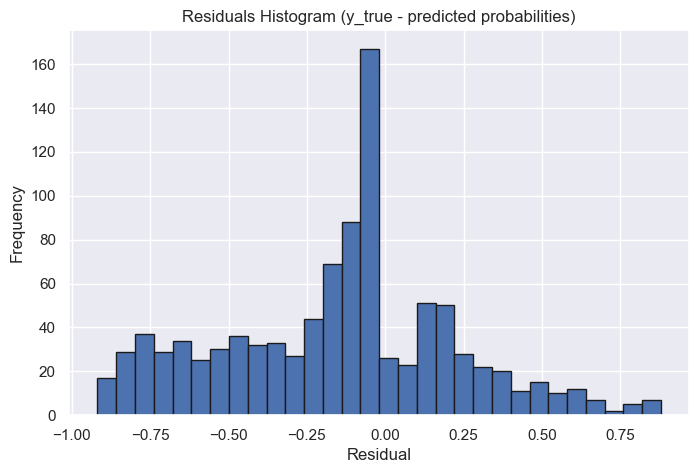

In [23]:
# Select best pipeline from SMOTE or ADASYN (example: SMOTE here)
best_pipeline = best_results['SMOTE'].best_estimator_

# Predict on test data
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report on Test Data:")
print(classification_report(y_test, y_pred))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Residual analysis: plot histogram of residuals (y_test - predicted probabilities)
residuals = y_test.astype(float) - y_proba
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residuals Histogram (y_true - predicted probabilities)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

### 4.5 Learning Curve

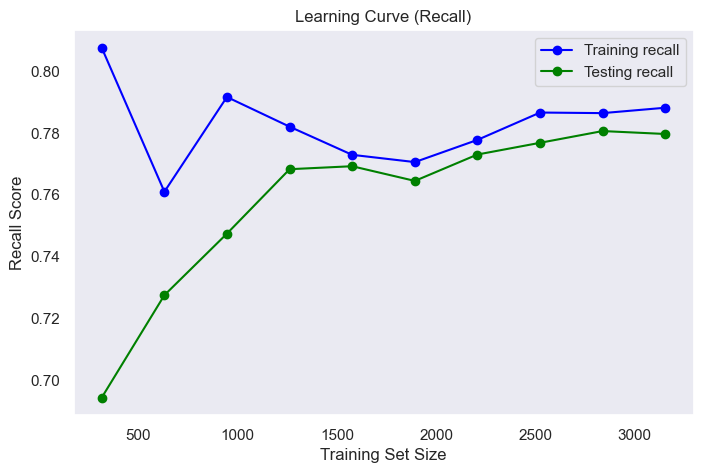

In [24]:
train_sizes, train_scores, test_scores = learning_curve(
    best_pipeline, X_train, y_train,
    cv=5, scoring='recall', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training recall')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Testing recall')
plt.title('Learning Curve (Recall)')
plt.xlabel('Training Set Size')
plt.ylabel('Recall Score')
plt.legend(loc='best')
plt.grid()
plt.show()

### 4.6 Threshold Tuning Using Youden's J Statistic

Recall Score before threshold tuning (threshold=0.5): 0.8137
Best threshold by Youden’s J statistic: 0.4773
TPR: 0.8403, FPR: 0.2918
Recall Score after threshold tuning (threshold=0.4773): 0.8403


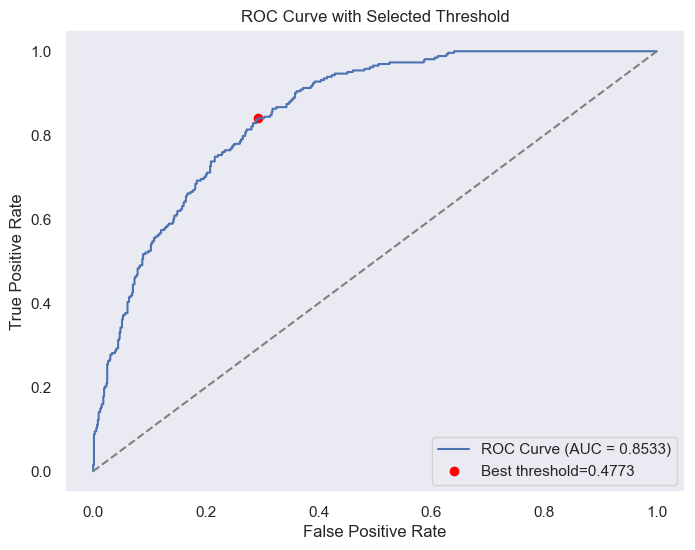

In [25]:
# Predicted probabilities
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Default threshold predictions
y_pred_default = (y_proba >= 0.5).astype(int)

# Recall before threshold tuning
recall_before = recall_score(y_test, y_pred_default)
print(f"Recall Score before threshold tuning (threshold=0.5): {recall_before:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Youden's J statistic
youden_j = tpr - fpr
best_idx = youden_j.argmax()
best_threshold = thresholds[best_idx]

print(f"Best threshold by Youden’s J statistic: {best_threshold:.4f}")
print(f"TPR: {tpr[best_idx]:.4f}, FPR: {fpr[best_idx]:.4f}")

# Apply new threshold
y_pred_new = (y_proba >= best_threshold).astype(int)
recall_after = recall_score(y_test, y_pred_new)
print(f"Recall Score after threshold tuning (threshold={best_threshold:.4f}): {recall_after:.4f}")

# Plot ROC curve with best threshold
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best threshold={best_threshold:.4f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Selected Threshold')
plt.legend()
plt.grid()
plt.show()

### 4.7 Threshold Tuning Using F1-score on Precision-Recall Curve

Best threshold by F1-score on PR curve: 0.5856
Precision: 0.5581, Recall: 0.7490, F1-score: 0.6396
Recall Score after threshold tuning (threshold=0.5856): 0.7490


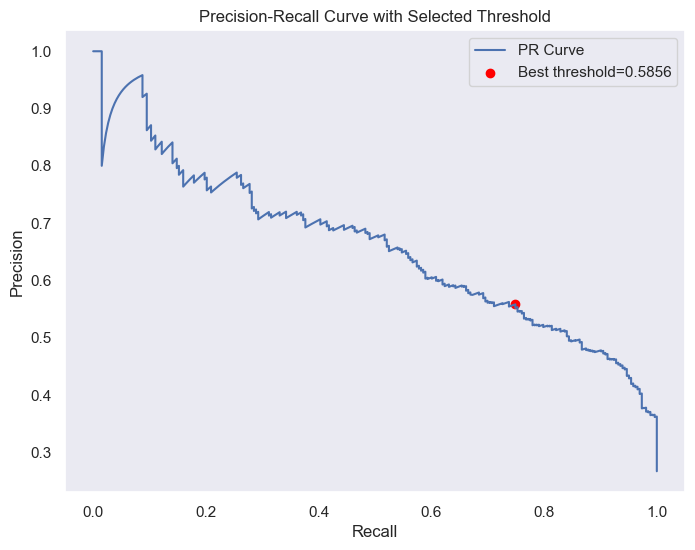

In [26]:
# Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # avoid division by zero

# Find best threshold
best_idx_pr = f1_scores.argmax()
best_threshold_pr = thresholds_pr[best_idx_pr] if best_idx_pr < len(thresholds_pr) else 1.0

print(f"Best threshold by F1-score on PR curve: {best_threshold_pr:.4f}")
print(f"Precision: {precision[best_idx_pr]:.4f}, Recall: {recall[best_idx_pr]:.4f}, F1-score: {f1_scores[best_idx_pr]:.4f}")

# Apply new threshold
y_pred_pr = (y_proba >= best_threshold_pr).astype(int)
recall_after_pr = recall_score(y_test, y_pred_pr)
print(f"Recall Score after threshold tuning (threshold={best_threshold_pr:.4f}): {recall_after_pr:.4f}")

# Plot Precision-Recall Curve with best threshold
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='PR Curve')
plt.scatter(recall[best_idx_pr], precision[best_idx_pr], color='red', label=f'Best threshold={best_threshold_pr:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Selected Threshold')
plt.legend()
plt.grid()
plt.show()

## Section 5. Evaluation
### 5.1 Baseline vs Tuned Model Performance Comparison

In [27]:
# Baseline pipeline with Logistic Regression without resampling or VIF filtering
baseline_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, n_jobs=-1, max_iter=1000))
])

# Fit baseline pipeline
baseline_pipe.fit(X_train, y_train)

# Predict and evaluate baseline
y_proba_baseline = baseline_pipe.predict_proba(X_test)[:, 1]
roc_auc_baseline = roc_auc_score(y_test, y_proba_baseline)
print(f"Baseline Logistic Regression ROC AUC: {roc_auc_baseline:.4f}")

# Predict and evaluate tuned model
y_proba_tuned = best_pipeline.predict_proba(X_test)[:, 1]
roc_auc_tuned = roc_auc_score(y_test, y_proba_tuned)
print(f"Tuned Logistic Regression ROC AUC: {roc_auc_tuned:.4f}")
print(f"Best parameters: {best_results['ADASYN'].best_params_}")

# Threshold adjustment using Youden's J statistic
fpr, tpr, thresholds = roc_curve(y_test, y_proba_tuned)
youden_j = tpr - fpr
best_idx = youden_j.argmax()
optimal_threshold = thresholds[best_idx]
print(f"Optimal threshold from ROC curve: {optimal_threshold:.4f}")

# Predictions with default and optimal thresholds
y_pred_default = (y_proba_tuned >= 0.5).astype(int)
y_pred_adjusted = (y_proba_tuned >= optimal_threshold).astype(int)

# Calculate recall
recall_default = recall_score(y_test, y_pred_default)
recall_adjusted = recall_score(y_test, y_pred_adjusted)

print(f"Recall with default threshold 0.5: {recall_default:.4f}")
print(f"Recall with optimal threshold {optimal_threshold:.4f}: {recall_adjusted:.4f}")

Baseline Logistic Regression ROC AUC: 0.8558
Tuned Logistic Regression ROC AUC: 0.8533
Best parameters: {'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Optimal threshold from ROC curve: 0.4773
Recall with default threshold 0.5: 0.8137
Recall with optimal threshold 0.4773: 0.8403


### 5.2 Model Explanation Using Statsmodels

In [28]:
# Prepare data for statsmodels logistic regression
X_train_preprocessed = preprocessor.fit_transform(X_train)
feature_names = get_feature_names(preprocessor)

X_train_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)

# Apply VIFSelector to remove high multicollinearity features
vif_selector = VIFSelector(threshold=10).set_feature_names(feature_names)
vif_selector.fit(X_train_df)
X_train_reduced = vif_selector.transform(X_train_df)

features_after_vif = [f for f in feature_names if f not in vif_selector.features_to_drop_]
X_train_final = pd.DataFrame(X_train_reduced, columns=features_after_vif)

# Align indices
X_train_final = X_train_final.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

# Add intercept
X_train_final = sm.add_constant(X_train_final)

# Fit logistic regression model for interpretation
model_sm = sm.Logit(y_train_reset, X_train_final)
result = model_sm.fit(disp=False)

# Display summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 3944
Model:                          Logit   Df Residuals:                     3932
Method:                           MLE   Df Model:                           11
Date:                Thu, 15 May 2025   Pseudo R-squ.:                  0.2681
Time:                        09:21:50   Log-Likelihood:                -1674.9
converged:                       True   LL-Null:                       -2288.5
Covariance Type:            nonrobust   LLR p-value:                2.381e-256
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.6364      0.184     -3.453      0.001      -0.998      -0.275
tenure                         -1.5033      0.134    -11.260      0.000      -1.765      -1.242
MonthlyCharges                  1.4599      0.218      6.711      0.000       1.034       1.886
Dependents                     -0.3156      0.106     -2.983      0.003      -0.523      -0.108
PaperlessBilling                0.4445      0.098      4.551      0.000       0.253       0.636
OnlineSecurity_Yes             -0.5333      0.115     -4.643      0.000      -0.758      -0.308
OnlineBackup_Yes               -0.2614      0.106     -2.471      0.013      -0.469      -0.054
InternetService_Fiber optic     0.1328      0.190      0.700      0.484      -0.239       0.505
DeviceProtection_Yes           -0.0237      0.111     -0.213      0.832      -0.242       0.194
TechSupport_Yes                -0.4456      0.119     -3.737      0.000      -0.679      -0.212
Contract_One year              -0.9661      0.141     -6.841      0.000      -1.243      -0.689
Contract_Two year              -1.3997      0.217     -6.452      0.000      -1.825      -0.975
===============================================================================================
"""

### 5.3 Feature Importance Using SHAP

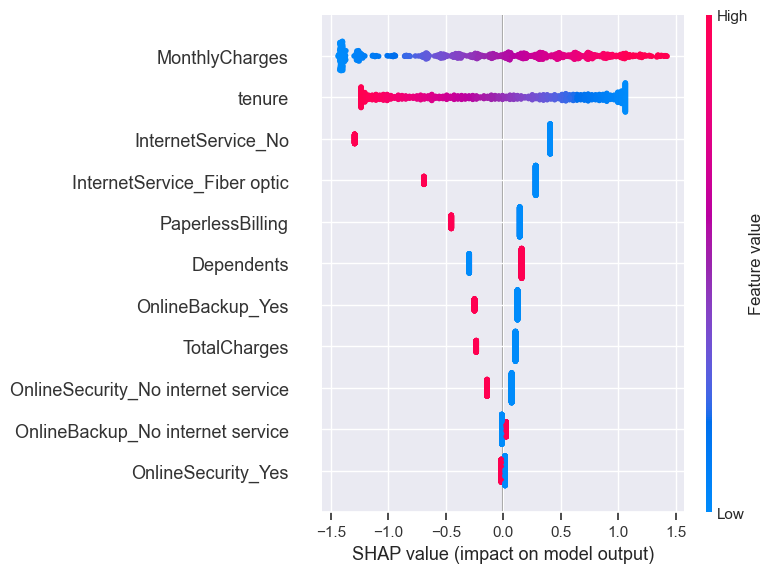

In [29]:
# Extract preprocessor and VIF selector from best pipeline
preprocessor_vif = ImbPipeline([
    ('preprocessor', best_pipeline.named_steps['preprocessor']),
    ('vif_selector', best_pipeline.named_steps['vif_selector'])
])

# Transform test data
X_test_preprocessed = preprocessor_vif.transform(X_test)

# Get feature names after preprocessing and VIF filtering
feature_names = get_feature_names(best_pipeline.named_steps['preprocessor'])
features_after_vif = [f for f in feature_names if f not in best_pipeline.named_steps['vif_selector'].features_to_drop_]

# Get trained classifier
model = best_pipeline.named_steps['classifier']

# Create SHAP explainer and calculate SHAP values
explainer = shap.LinearExplainer(model, X_test_preprocessed, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_preprocessed)

# Plot SHAP summary
shap.summary_plot(shap_values, features=X_test_preprocessed, feature_names=features_after_vif)

### 5.4 Confusion Matrix Visualization

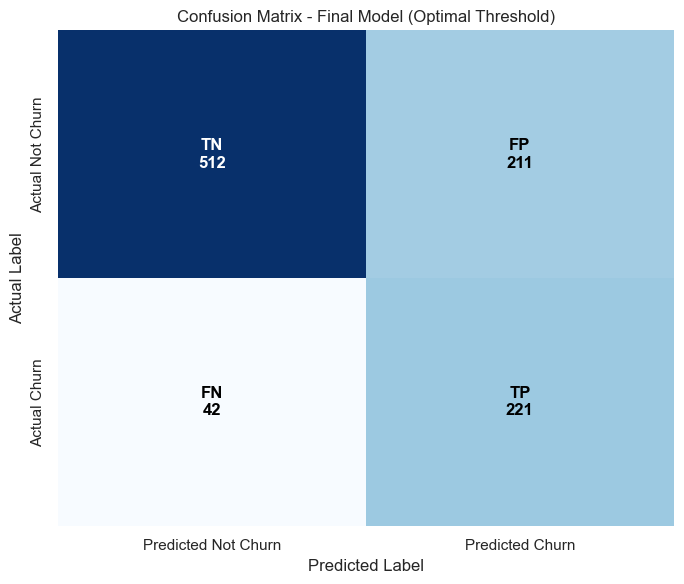

In [30]:
# Compute confusion matrix for adjusted threshold predictions
cm = confusion_matrix(y_test, y_pred_adjusted)
class_labels = ['Not Churn', 'Churn']

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f'Predicted {label}' for label in class_labels],
            yticklabels=[f'Actual {label}' for label in class_labels])

# Add annotations for TP, TN, FP, FN
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == 0 and j == 0:
            label = f'TN\n{cm[i, j]}'
        elif i == 1 and j == 1:
            label = f'TP\n{cm[i, j]}'
        elif i == 0 and j == 1:
            label = f'FP\n{cm[i, j]}'
        else:  # i == 1 and j == 0
            label = f'FN\n{cm[i, j]}'
        plt.text(j + 0.5, i + 0.5, label,
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black',
                 fontsize=12, fontweight='bold')

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix - Final Model (Optimal Threshold)')
plt.tight_layout()
plt.show()

## Section 6. Deployment
### 6.1 Save Model Using Joblib

In [31]:
# Save the best pipeline
model_filename = 'best_churn_model.joblib'
joblib.dump(best_pipeline, model_filename)
print(f"Model saved to {model_filename}")

Model saved to best_churn_model.joblib


### 6.2 How to Load and Use Saved Model

In [32]:
# Load model
loaded_model = joblib.load(model_filename)

# Example prediction
sample = X_test.iloc[:5]
predictions = loaded_model.predict(sample)
print("Sample predictions:", predictions)

Sample predictions: [1 1 0 1 0]


### 6.3 Model Limitations
- Model depends on data quality and feature relevance.
- Changes in customer behavior or services may reduce model accuracy over time.
- Periodic retraining and monitoring are recommended.

## Section 7. Conclusion and Recommendations
### 7.1 Conclusion
- Developed model predicts churn with good recall and ROC-AUC.
- Identified key factors influencing churn with interpretable methods.
- Threshold tuning improved recall, important for business objectives.

### 7.2 Recommendations
- Regularly update and monitor model performance.
- Use insights to improve customer retention strategies.
- Consider deploying model with monitoring for data drift.

## References
- Scikit-learn documentation: https://scikit-learn.org/stable/
- SHAP documentation: https://shap.readthedocs.io/en/latest/
- Statsmodels documentation: https://www.statsmodels.org/stable/index.html
- Imbalanced-learn documentation: https://imbalanced-learn.org/stable/
- Variance Inflation Factor explanation: https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html